# Binary Classification of the PIMA Indians Diabetes Dataset

This notebook demonstrates a **machine learning workflow** for binary classification:  
predicting whether a patient has diabetes based on clinical features.  

**Key challenges**: class imbalance and moderate dataset size

---

## Steps in this notebook

1. **Load the dataset**
   - Import data and perform initial exploration  
<br>
2. **Preprocess the data**  
   - Train/test split  
   - Standard scaling of numeric features  
<br>
3. **Train a baseline model**  
   - Logistic Regression  
<br>
4. **Evaluate model performance**  
   - Confusion matrix, sensitivity, specificity, accuracy  
   - ROC curve and AUROC  
   - Precision–Recall curve and Average Precision (for imbalanced data)  
<br>
5. **Explore decision thresholds**  
   - Threshold analysis to select an optimal operating point  
<br>
6. **Make predictions**  
   - Example prediction with clinical input features  

---

## Dataset
- **Pima Indians Diabetes Dataset (UCI classic)**: each row represents a patient with clinical measurements such as age, BMI, blood pressure, glucose, insulin, pregnancies, and a binary outcome (`1 = diabetes`, `0 = no diabetes`).  
- Source: [Kaggle – Pima Indians Diabetes Database (2016)](https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database)  


## Import libraries

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, 
    roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
)
import seaborn as sns
import matplotlib.pyplot as plt

## 1. Load the dataset

In [2]:
file_path = "./PIMA_Indians_Diabetes.csv"
data = pd.read_csv(file_path)

In [3]:
print(f"Dataset dimensions: {data.shape}\n")
data.head()

Dataset dimensions: (768, 9)



,Age,BMI,BloodPressure,Glucose,Insulin,SkinThickness,Pregnancies,DiabetesPedigree,Outcome
0,50,33.6,72,148,0,35,6,0.627,1
1,31,26.6,66,85,0,29,1,0.351,0
2,32,23.3,64,183,0,0,8,0.672,1
3,21,28.1,66,89,94,23,1,0.167,0
4,33,43.1,40,137,168,35,0,2.288,1


## 2. Preprocessing the data

### Split into features (X) and target (y)

In [4]:
X = data.drop("Outcome", axis=1)
y = data["Outcome"]

### Create training and test sets with stratification to preserve class balance

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=21, stratify=y
)

### Standardize features to improve model performance

In [6]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 3. Train a baseline ML model

### Logistic Regression is a good baseline for binary classification

In [7]:
model = LogisticRegression(max_iter=1000, random_state=21)
model.fit(X_train_scaled, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,21
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


## 4. Evaluate the model performance

### Predictions

In [9]:
y_pred = model.predict(X_test_scaled)
y_pred_prob = model.predict_proba(X_test_scaled)[:, 1]

In [10]:
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.89      0.82       100
           1       0.70      0.48      0.57        54

    accuracy                           0.75       154
   macro avg       0.73      0.69      0.70       154
weighted avg       0.74      0.75      0.73       154

Accuracy: 0.7467532467532467


### Confusion matrix visualization

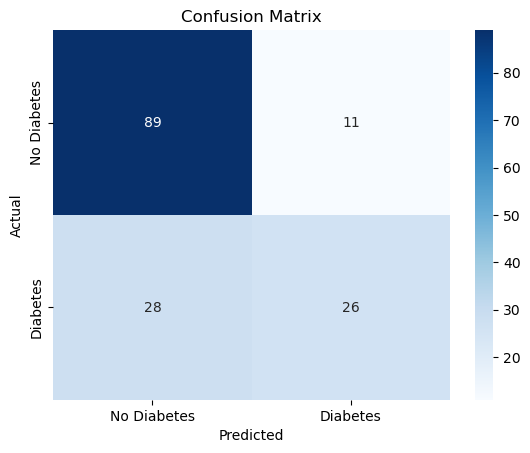

In [11]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=["No Diabetes", "Diabetes"],
    yticklabels=["No Diabetes", "Diabetes"]
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### Sensitivity (Recall for positive class) and Specificity (Recall for negative class)

In [12]:
TN, FP, FN, TP = cm.ravel()
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

In [13]:
print(f"Sensitivity (Recall for Diabetes): {sensitivity:.2f}")
print(f"Specificity (Recall for No Diabetes): {specificity:.2f}")

Sensitivity (Recall for Diabetes): 0.48
Specificity (Recall for No Diabetes): 0.89


### ROC curve and AUC

In [14]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test, y_pred_prob)

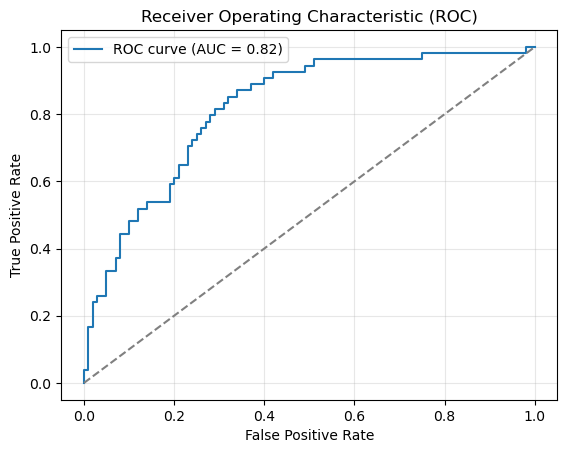

In [15]:
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [16]:
print(f"AUROC: {auc:.2f}")

AUROC: 0.82


### Precision-Recall curve (useful for imbalanced datasets)

In [17]:
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_pred_prob)
avg_precision = average_precision_score(y_test, y_pred_prob)

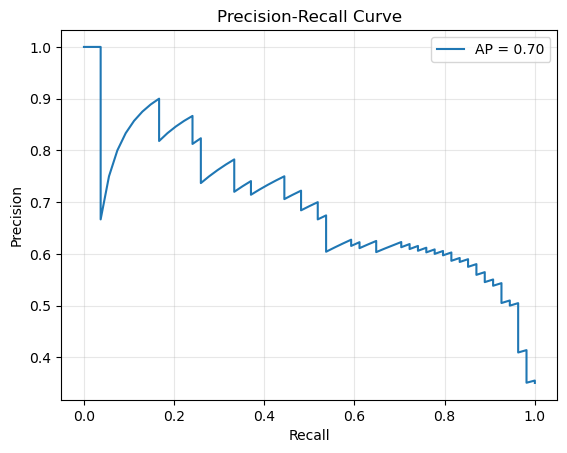

In [18]:
plt.plot(recall, precision, label=f"AP = {avg_precision:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [19]:
print(f"Average Precision Score: {avg_precision:.2f}")

Average Precision Score: 0.70


## 5. Explore decision thresholds

### Identify an optimal threshold using Youden's J statistic

In [20]:
def evaluate_threshold(threshold: float):
    """
    Evaluate accuracy, sensitivity, and specificity at a given threshold
    """
    y_pred_thresh = (y_pred_prob >= threshold).astype(int)
    cm_thresh = confusion_matrix(y_test, y_pred_thresh)
    TN, FP, FN, TP = cm_thresh.ravel()
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    acc = accuracy_score(y_test, y_pred_thresh)
    return acc, sensitivity, specificity

**Try a few example thresholds**

In [21]:
for t in [0.3, 0.5, 0.7]:
    acc, sens, spec = evaluate_threshold(t)
    print(f"Threshold = {t:.2f} | Accuracy = {acc:.2f} | Sensitivity = {sens:.2f} | Specificity = {spec:.2f}")

Threshold = 0.30 | Accuracy = 0.74 | Sensitivity = 0.72 | Specificity = 0.75
Threshold = 0.50 | Accuracy = 0.75 | Sensitivity = 0.48 | Specificity = 0.89
Threshold = 0.70 | Accuracy = 0.72 | Sensitivity = 0.30 | Specificity = 0.95


### Plot metrics across a range of thresholds

In [22]:
thresholds = np.linspace(0, 1, 100)
accuracies, sensitivities, specificities, j_scores = [], [], [], []

for thr in thresholds:
    acc, sens, spec = evaluate_threshold(thr)
    accuracies.append(acc)
    sensitivities.append(sens)
    specificities.append(spec)
    j_scores.append(sens + spec - 1)  # Youden's J statistic

### Find optimal threshold (maximizes Youden's J statistic)
**balance sensitivity and specificity**

In [23]:
optimal_idx = np.argmax(j_scores)
optimal_threshold = thresholds[optimal_idx]
optimal_acc, optimal_sens, optimal_spec = evaluate_threshold(optimal_threshold)

In [24]:
print(f"Optimal threshold by Youden's J: {optimal_threshold:.2f}")
print(f"At optimal threshold -> Accuracy: {optimal_acc:.2f}, Sensitivity: {optimal_sens:.2f}, Specificity: {optimal_spec:.2f}")

Optimal threshold by Youden's J: 0.21
At optimal threshold -> Accuracy: 0.73, Sensitivity: 0.87, Specificity: 0.66


### Plot Accuracy, Sensitivity, and Specificity curves with optimal threshold marked

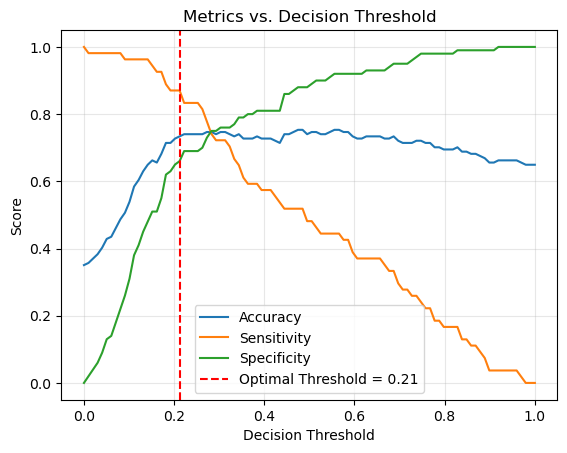

In [25]:
plt.plot(thresholds, accuracies, label="Accuracy")
plt.plot(thresholds, sensitivities, label="Sensitivity")
plt.plot(thresholds, specificities, label="Specificity")
plt.axvline(
    optimal_threshold, color="red", linestyle="--",
    label=f"Optimal Threshold = {optimal_threshold:.2f}"
)
plt.xlabel("Decision Threshold")
plt.ylabel("Score")
plt.title("Metrics vs. Decision Threshold")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

### Confusion Matrix for the optimal threshold

In [26]:
def cm_threshold(threshold: float):
    """
    Get confusion matrix a given threshold.
    """
    y_pred_thresh = (y_pred_prob >= threshold).astype(int)
    cm_thresh = confusion_matrix(y_test, y_pred_thresh)
    return cm_thresh

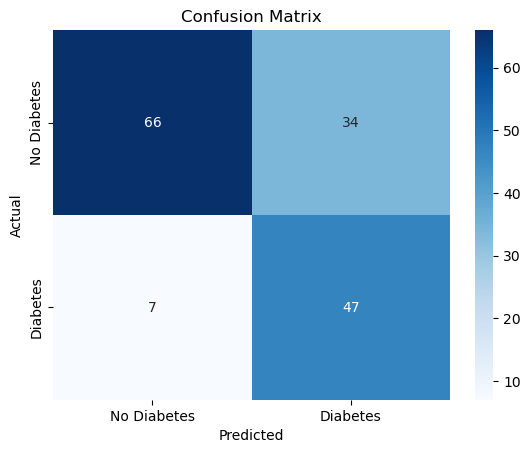

In [27]:
cm = cm_threshold(optimal_threshold)
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=["No Diabetes", "Diabetes"],
    yticklabels=["No Diabetes", "Diabetes"]
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## 6. Make prediction

**Prediction at default threshold**

In [28]:
example = pd.DataFrame([{'Age':85, 'BMI':25.5, 'BloodPressure':70, 'Glucose':120, 'Insulin':79, 'SkinThickness':20, 
                         'Pregnancies':2, 'DiabetesPedigree':0.35}])
example_scaled = scaler.transform(example)

pred = model.predict(example_scaled)

status = {0: "No Diabetes", 1: "Diabetes"}

print(f"Example prediction: {pred[0]} => {status.get(pred[0])}")

Example prediction: 0 => No Diabetes


**Prediction at optimal threshold**

In [29]:
prob = model.predict_proba(example_scaled)[0, 1]
pred_at_optimal = int(prob >= optimal_threshold)

print(f"Example probability of diabetes: {prob:.2f}")
print(f"Example prediction at optimal threshold ({optimal_threshold:.2f}): {pred_at_optimal} => {status.get(pred_at_optimal)}")

Example probability of diabetes: 0.26
Example prediction at optimal threshold (0.21): 1 => Diabetes


## THIS IS THE END!

### Best of luck :)